In [1]:
install.packages("glmnet")
install.packages("caret")
install.packages("dplyr")
install.packages("pROC")
install.packages("rsample")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp478Khw/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp478Khw/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp478Khw/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp478Khw/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp478Khw/downloaded_packages


In [1]:
library(glmnet)
library(caret)
library(dplyr)
library(pROC)
library(rsample)

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




# Import and format data

In [16]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
#check col names and structure
#names(data)
#str(data)
#new df without  cols not used
trim_data <- data %>% select(-identifier, -score_min, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)
trim_scaled <-trim_data
trim_scaled[, -which(names(trim_data) == "serviceable_agg")] <- scale(trim_data[, -which(names(trim_data) == "serviceable_agg")])
#remove problematic cols
#trim_data <- trim_data %>% select(-IT01V_frameHeight_ellen, -IT01V_frameHeight_aadya)
#trim_data <- trim_data %>% select(-IT01V_frameWidth_ellen, -IT01V_frameWidth_aadya)
#remove all aadya cols
#trim_data <- trim_data %>% select(-contains("aadya"))
#remove all outbound cols
#trim_data <- trim_data %>% select(-contains("OT01V"))
#trim_data <- trim_data %>% select(-contains("OT01A"))


In [3]:
min_values <- sapply(trim_data, min, na.rm = TRUE)
max_values <- sapply(trim_data, max, na.rm = TRUE)
range_values <- max_values - min_values

# Combine min, max, and range into a data frame
summary_df <- data.frame(
  Min = min_values,
  Max = max_values,
  Range = range_values
)

# Print the nicely formatted table
cat("Column-wise Min, Max, and Range:\n")
#print(summary_df)

Column-wise Min, Max, and Range:


Divide into train and test

In [17]:
set.seed(4)

# Create stratified training and testing sets
split_data <- initial_split(trim_scaled, prop = 0.7, strata = "serviceable_agg")
train_data <- training(split_data)
test_data <- testing(split_data)

# Display the distribution of 'serviceable_agg' in training and testing sets
train_ratios <- prop.table(table(train_data$serviceable_agg))
test_ratios <- prop.table(table(test_data$serviceable_agg))
original_ratios <- prop.table(table(trim_data$serviceable_agg))


format as matrices for fitting

In [18]:
x_train <- as.matrix(train_data[, -which(names(train_data) == "serviceable_agg")])
y_train <- train_data$serviceable_agg

x_test <- as.matrix(test_data[, -which(names(test_data) == "serviceable_agg")])
y_test <- test_data$serviceable_agg

# Approach 1: Setting alpha manually

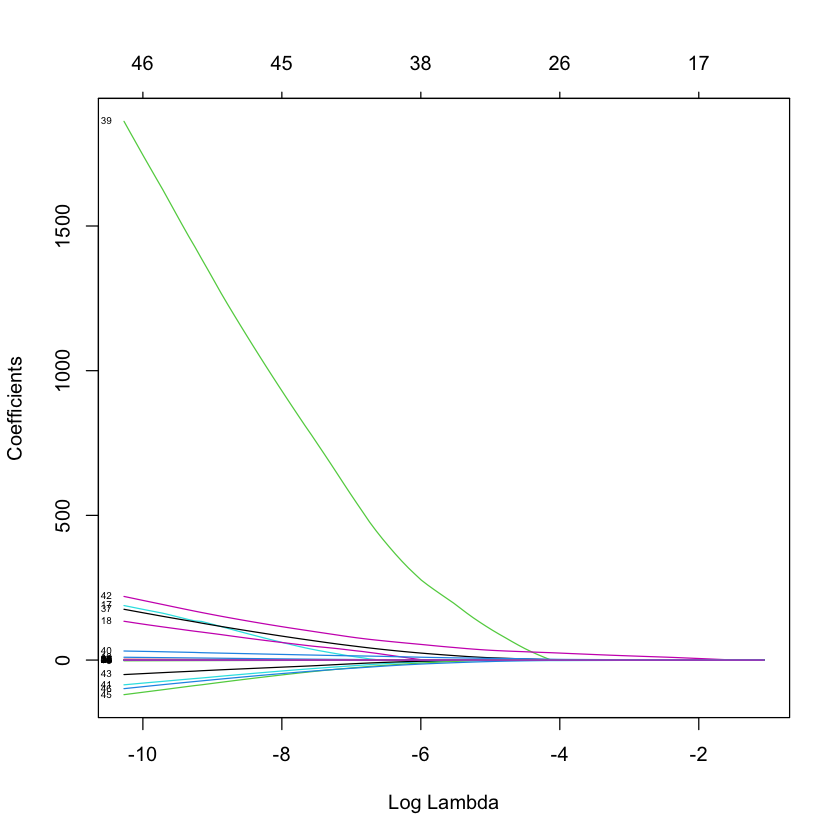

49 x 1 sparse Matrix of class "dgCMatrix"
                                                              s0
(Intercept)                                        -3.3716216053
IT01V_packetsRecieved_ellen                         .           
IT01V_packetsRecieved_aadya                         0.0011417743
IT01V_packetsLost_ellen                            -0.0117370333
IT01V_packetsLost_aadya                             0.0463107483
IT01V_frameWidth_ellen                              0.0002884966
IT01V_frameWidth_aadya                              .           
IT01V_frameHeight_ellen                             0.0005120956
IT01V_frameHeight_aadya                             .           
IT01V_totalFreezesDuration_ellen                    .           
IT01V_totalFreezesDuration_aadya                    .           
IT01V_framesPerSecond_ellen                         0.0342245565
IT01V_framesPerSecond_aadya                         .           
IT01V_bytesReceived_in_bits_s_ellen             

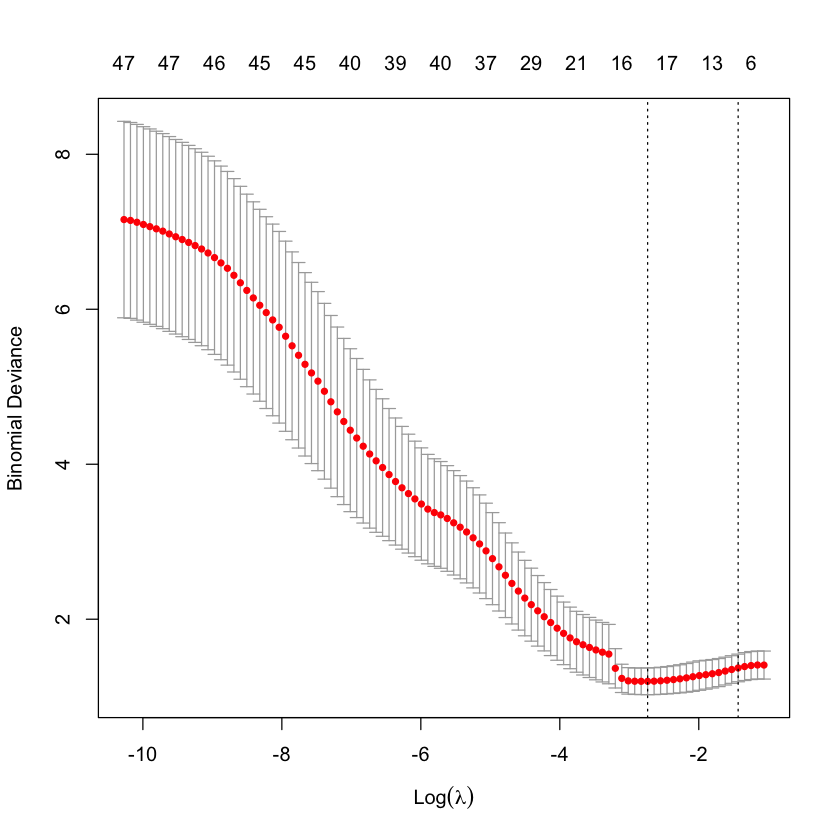

In [7]:
# alpha = 0.5(elastic net)
par(bg= "white")
model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the coefficient paths
plot(model_manual, xvar = "lambda", label = TRUE)

# Perform cross-validation to find the optimal lambda
cv_model_manual <- cv.glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the cross-validation curve
plot(cv_model_manual)

# Get the best lambda
best_lambda <- cv_model_manual$lambda.min

# Fit the final model with the best lambda
final_model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5, lambda = best_lambda)

# Print the coefficients
coef(final_model_manual)

### Summary of output

In [8]:
#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_manual))[-1][coef(final_model_manual)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
summary(logistic_model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = formula, family = "binomial", data = train_data)

Coefficients: (1 not defined because of singularities)
                                                     Estimate Std. Error
(Intercept)                                        -6.794e+15  5.084e+07
IT01V_packetsRecieved_aadya                        -9.225e+12  3.539e+05
IT01V_packetsLost_ellen                            -7.091e+12  5.245e+06
IT01V_packetsLost_aadya                             9.449e+13  2.981e+06
IT01V_frameWidth_ellen                              1.498e+13  3.470e+05
IT01V_frameHeight_ellen                                    NA         NA
IT01V_framesPerSecond_ellen                        -4.328e+13  5.718e+06
IT01V_totalProcessingDelay_aadya                   -2.783e+13  4.547e+05
IT01V_jitterBufferDelay_emissions_aadya            -3.366e+12  1.579e+05
OT01V_frameWidth_aadya                             -1.046e+13  3.565e+05
OT01V_framesPerSecond_ellen                         5.503e+12  1.870e+0

# Approach 2: Using cross-validation to find the optimal alpha

Function to perform cross validation of the elastic net mixing parameter alpha

In [19]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, family = "binomial", alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)
}

execution of cv for alpha and lambda

Best alpha: 0.9 
[1] 0.03281764


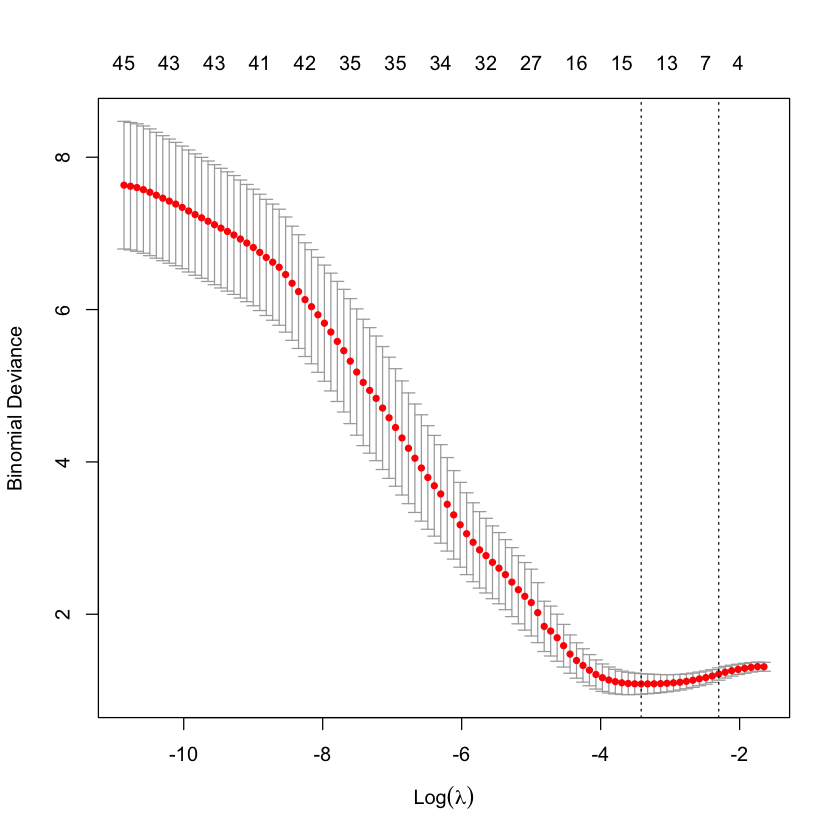

In [20]:
# Find the best alpha
best_alpha <- cv_alpha(x_train_scaled, y_train)
cat("Best alpha:", best_alpha, "\n")

# Fit the model with the best alpha
cv_model_best <- cv.glmnet(x_train_scaled, y_train, family = "binomial", alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)
# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x_train_scaled, y_train, family = "binomial", alpha = best_alpha, lambda = best_lambda)


### selected variables

In [21]:
lasso_coefficients <- coef(final_model_best)
# Display coefficients
print("Lasso Coefficients:")
print(lasso_coefficients)

[1] "Lasso Coefficients:"
49 x 1 sparse Matrix of class "dgCMatrix"
                                                            s0
(Intercept)                                        -1.06559047
IT01V_packetsRecieved_ellen                         .         
IT01V_packetsRecieved_aadya                         .         
IT01V_packetsLost_ellen                            -0.01353992
IT01V_packetsLost_aadya                             0.20866324
IT01V_frameWidth_ellen                              0.04127941
IT01V_frameWidth_aadya                              .         
IT01V_frameHeight_ellen                             0.04787593
IT01V_frameHeight_aadya                             .         
IT01V_totalFreezesDuration_ellen                    .         
IT01V_totalFreezesDuration_aadya                    .         
IT01V_framesPerSecond_ellen                         0.22410313
IT01V_framesPerSecond_aadya                         .         
IT01V_bytesReceived_in_bits_s_ellen               

find pvalues by refitting a logistic model with the desired variables

In [22]:

selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# 3. Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# 4. Fit a standard logistic regression model using the scaled training data
logistic_model <- glm(formula, data = train_data, family = "binomial")

# 5. Get the summary of the model, which includes p-values
summary_output <- summary(logistic_model)

# 6. Extract coefficients and p-values
coef_summary <- data.frame(
  Estimate = summary_output$coefficients[, "Estimate"],
  `Std. Error` = summary_output$coefficients[, "Std. Error"],
  `z value` = summary_output$coefficients[, "z value"],
  `Pr(>|z|)` = summary_output$coefficients[, "Pr(>|z|)"]
)

# 7. Display the results
print(coef_summary)


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                                                      Estimate   Std..Error
(Intercept)                                        -27.6126450   36.1920379
IT01V_packetsLost_ellen                             -0.4989688    0.8359373
IT01V_packetsLost_aadya                              1.4810145    1.1158837
IT01V_frameWidth_ellen                              85.0943541 3098.8705624
IT01V_framesPerSecond_ellen                          5.0018188    7.3594027
IT01V_totalProcessingDelay_aadya                    -2.8814358    1.8561851
IT01V_jitterBufferDelay_emissions_aadya              1.1708697    2.1883726
OT01V_frameWidth_aadya                             -25.7381124 3100.9321867
OT01V_framesPerSecond_ellen                          0.4325942    0.9572527
OT01V_framesPerSecond_aadya                          2.0109366    6.1035865
OT01V_totalPacketSendDelay_packetsSent_in_ms_ellen  -1.6522060    6.3650268
RIV_roundTripTime_aadya                            -35.9976901   67.8331824
RIA_fraction

In [23]:
#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
# Get the summary of the model, which includes p-values
summary_output <- summary(logistic_model)

# Extract coefficients and p-values
coef_summary <- data.frame(
  Estimate = summary_output$coefficients[, "Estimate"],
  `Std. Error` = summary_output$coefficients[, "Std. Error"],
  `z value` = summary_output$coefficients[, "z value"],
  `Pr(>|z|)` = summary_output$coefficients[, "Pr(>|z|)"]
)

# Display the results
print(coef_summary)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                                                      Estimate   Std..Error
(Intercept)                                        -27.6126450   36.1920379
IT01V_packetsLost_ellen                             -0.4989688    0.8359373
IT01V_packetsLost_aadya                              1.4810145    1.1158837
IT01V_frameWidth_ellen                              85.0943541 3098.8705624
IT01V_framesPerSecond_ellen                          5.0018188    7.3594027
IT01V_totalProcessingDelay_aadya                    -2.8814358    1.8561851
IT01V_jitterBufferDelay_emissions_aadya              1.1708697    2.1883726
OT01V_frameWidth_aadya                             -25.7381124 3100.9321867
OT01V_framesPerSecond_ellen                          0.4325942    0.9572527
OT01V_framesPerSecond_aadya                          2.0109366    6.1035865
OT01V_totalPacketSendDelay_packetsSent_in_ms_ellen  -1.6522060    6.3650268
RIV_roundTripTime_aadya                            -35.9976901   67.8331824
RIA_fraction

predictions

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.8055556 


Warning message:
"Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`)."


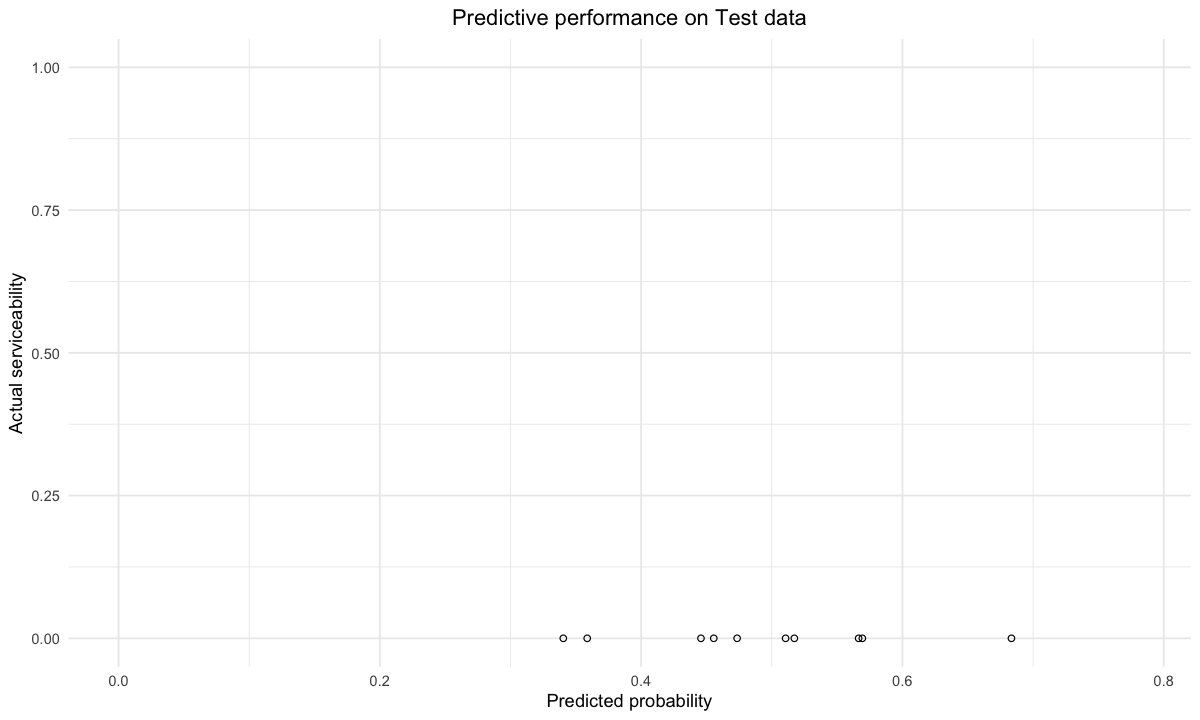

In [24]:
par(bg= "white")
options(repr.plot.width = 10, repr.plot.height = 6)
# Make predictions on the test set
predictions <- predict(final_model_best, newx = x_test, type = "response", data = trim_data)
predictions_vector <- predictions[, 1]
# Evaluate the model
library(pROC)
roc_curve <- roc(y_test, predictions_vector)
auc_value <- auc(roc_curve)
cat("AUC:", auc_value, "\n")

# Plot ROC curve
#plot(roc_curve, main = "ROC Curve")

prediction_data <- data.frame(Actual = as.numeric(y_test), Predicted = predictions_vector)
prediction_data$Actual <- as.numeric(as.character(prediction_data$Actual)) - 1

options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(prediction_data, aes(x = Predicted, y = Actual)) +
  geom_point(shape = 1, color = "black", alpha = 1) +  # Use shape 1 for empty circles
  #geom_smooth(method = "lm", color = "blue", se = FALSE, size = 0.5) +  # Add a linear regression line
  labs(title = "Predictive performance on Test data", x = "Predicted probability", y = "Actual serviceability") +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))


In [25]:
# Convert probabilities into binary class predictions (threshold = 0.5)
threshold <- 0.45
predicted_classes <- ifelse(predictions_vector > threshold, 1, 0)

# Create a confusion matrix
library(caret)
predicted_classes <- factor(predicted_classes)
y_test <- factor(y_test)

# Ensure levels match for confusion matrix
predicted_classes <- factor(predicted_classes, levels = levels(y_test))

# Confusion Matrix
conf_matrix <- confusionMatrix(predicted_classes, y_test)
print(conf_matrix)


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 14  3
         1  4  7
                                          
               Accuracy : 0.75            
                 95% CI : (0.5513, 0.8931)
    No Information Rate : 0.6429          
    P-Value [Acc > NIR] : 0.1622          
                                          
                  Kappa : 0.4674          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.7778          
            Specificity : 0.7000          
         Pos Pred Value : 0.8235          
         Neg Pred Value : 0.6364          
             Prevalence : 0.6429          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.6071          
      Balanced Accuracy : 0.7389          
                                          
       'Positive' Class : 0               
                                    

# Decision tree

In [14]:
install.packages("rpart")
install.packages("caret")
install.packages("smotefamily")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpaCzkSa/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpaCzkSa/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpaCzkSa/downloaded_packages


In [15]:
install.packages("themis")
library(rpart)
library(caret)
library(themis)


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpaCzkSa/downloaded_packages


Loading required package: recipes


Attaching package: 'recipes'


The following object is masked from 'package:Matrix':

    update


The following object is masked from 'package:stats':

    step




## preparing the data

In [16]:
y_train <- as.factor(train_data$serviceable_agg)
y_test <- as.factor(test_data$serviceable_agg)
# Convert y_train and y_test to factors with valid levels
levels(y_train) <- c("Class0", "Class1")
levels(y_test) <- c("Class0", "Class1")
train_data_combined <- data.frame(x_train, serviceable_agg = y_train)
# Combine x_train and y_train again
train_data_combined <- data.frame(x_train, serviceable_agg = y_train)


## training the model

In [17]:
train_control <- trainControl(method = "cv", 
                              number = 10, 
                              classProbs = TRUE,  # Enable class probabilities
                              summaryFunction = twoClassSummary,  # Use for classification
                              sampling = "smote")  # Apply SMOTE during cross-validation


# Train a classification tree model
model <- train(serviceable_agg ~ ., 
               data = train_data_combined, 
               method = "rpart", 
               #comment these out to not do hyperparameter training
               #trControl = train_control,
               #tuneGrid = expand.grid(cp = seq(0.01, 0.1, by = 0.01)))
)

In [105]:
model_rf <- train(serviceable_agg ~ ., 
                  data = train_data_combined, 
                  method = "rf", 
                  trControl = train_control)
predictions_rf <- predict(model_rf, newdata = x_test)
confusionMatrix(predictions_rf, y_test)

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."


Confusion Matrix and Statistics

          Reference
Prediction Class0 Class1
    Class0     15      6
    Class1      3      4
                                          
               Accuracy : 0.6786          
                 95% CI : (0.4765, 0.8412)
    No Information Rate : 0.6429          
    P-Value [Acc > NIR] : 0.4293          
                                          
                  Kappa : 0.25            
                                          
 Mcnemar's Test P-Value : 0.5050          
                                          
            Sensitivity : 0.8333          
            Specificity : 0.4000          
         Pos Pred Value : 0.7143          
         Neg Pred Value : 0.5714          
             Prevalence : 0.6429          
         Detection Rate : 0.5357          
   Detection Prevalence : 0.7500          
      Balanced Accuracy : 0.6167          
                                          
       'Positive' Class : Class0          
            

In [18]:
install.packages("gbm")
library(gbm)


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpaCzkSa/downloaded_packages


Warning message:
"package 'gbm' was built under R version 4.3.3"
Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



In [19]:
model_gbm <- train(serviceable_agg ~ ., 
                   data = train_data_combined, 
                   method = "gbm", 
                   trControl = train_control)
predictions_gbm <- predict(model_gbm, newdata = x_test)
confusionMatrix(predictions_gbm, y_test)

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3409             nan     0.1000    0.0108
     2        1.3010             nan     0.1000    0.0079
     3        1.2522             nan     0.1000    0.0191
     4        1.1967             nan     0.1000    0.0239
     5        1.1615             nan     0.1000    0.0033
     6        1.1320             nan     0.1000    0.0012
     7        1.1011             nan     0.1000    0.0055
     8        1.0746             nan     0.1000    0.0074
     9        1.0431             nan     0.1000    0.0066
    10        1.0030             nan     0.1000    0.0118
    20        0.8207             nan     0.1000    0.0006
    40        0.5922             nan     0.1000   -0.0026
    60        0.4555             nan     0.1000   -0.0040
    80        0.3871             nan     0.1000    0.0005
   100        0.3237             nan     0.1000   -0.0021
   120        0.2630             nan     0.1000   -0.0025
   140        

Confusion Matrix and Statistics

          Reference
Prediction Class0 Class1
    Class0     15      6
    Class1      3      4
                                          
               Accuracy : 0.6786          
                 95% CI : (0.4765, 0.8412)
    No Information Rate : 0.6429          
    P-Value [Acc > NIR] : 0.4293          
                                          
                  Kappa : 0.25            
                                          
 Mcnemar's Test P-Value : 0.5050          
                                          
            Sensitivity : 0.8333          
            Specificity : 0.4000          
         Pos Pred Value : 0.7143          
         Neg Pred Value : 0.5714          
             Prevalence : 0.6429          
         Detection Rate : 0.5357          
   Detection Prevalence : 0.7500          
      Balanced Accuracy : 0.6167          
                                          
       'Positive' Class : Class0          
            

In [20]:
predictions <- predict(model, newdata = x_test)
confusionMatrix(predictions, y_test)

Confusion Matrix and Statistics

          Reference
Prediction Class0 Class1
    Class0     14      5
    Class1      4      5
                                          
               Accuracy : 0.6786          
                 95% CI : (0.4765, 0.8412)
    No Information Rate : 0.6429          
    P-Value [Acc > NIR] : 0.4293          
                                          
                  Kappa : 0.2841          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.7778          
            Specificity : 0.5000          
         Pos Pred Value : 0.7368          
         Neg Pred Value : 0.5556          
             Prevalence : 0.6429          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.6786          
      Balanced Accuracy : 0.6389          
                                          
       'Positive' Class : Class0          
            